# Simple orders analysis

My goal is to get an initial understanding of:
- `orders` properties
- their associated `review_scores`

## Import modules

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
root_path = os.path.join(os.getcwd(),'..')
if root_path not in sys.path:
    sys.path.append(root_path)

from utils.order import Order

order_instance = Order()
orders = order_instance.get_training_data(with_distance_seller_customer=True)

## 1. Inspect features

👀 **Printing summary statistics of each column of the order dataset**

In [4]:
orders.describe()


,wait_time,expected_wait_time,delay_vs_expected,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
count,95872.000000,95872.000000,95872.000000,95872.000000,95872.000000,95872.000000,95872.000000,95872.000000,95872.000000,95872.000000,95872.000000
mean,12.513442,23.739059,0.753349,0.592112,0.097651,4.155509,1.141783,1.013914,136.692876,22.749945,600.673668
std,9.454868,8.766518,4.656587,0.491445,0.296844,1.285113,0.535848,0.123635,207.672996,21.517061,594.818600
min,0.533414,2.008009,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.850000,0.000000,0.000000
25%,6.754850,18.326979,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,45.900000,13.820000,187.199770
50%,10.203727,23.230556,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,85.990000,17.160000,433.943032
75%,15.659560,28.414525,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,149.900000,23.990000,797.505559
max,208.351759,155.135463,188.975081,1.000000,1.000000,5.000000,21.000000,5.000000,13440.000000,1794.960000,8736.947618


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95872 entries, 0 to 95879
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  95872 non-null  object 
 1   wait_time                 95872 non-null  float64
 2   expected_wait_time        95872 non-null  float64
 3   delay_vs_expected         95872 non-null  float64
 4   order_status              95872 non-null  object 
 5   dim_is_five_star          95872 non-null  int64  
 6   dim_is_one_star           95872 non-null  int64  
 7   review_score              95872 non-null  int64  
 8   number_of_products        95872 non-null  int64  
 9   number_of_sellers         95872 non-null  int64  
 10  price                     95872 non-null  float64
 11  freight_value             95872 non-null  float64
 12  distance_seller_customer  95872 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 10.2+ MB


👀 **Plotting histograms to get a sense of the distribution of each numerical feature**

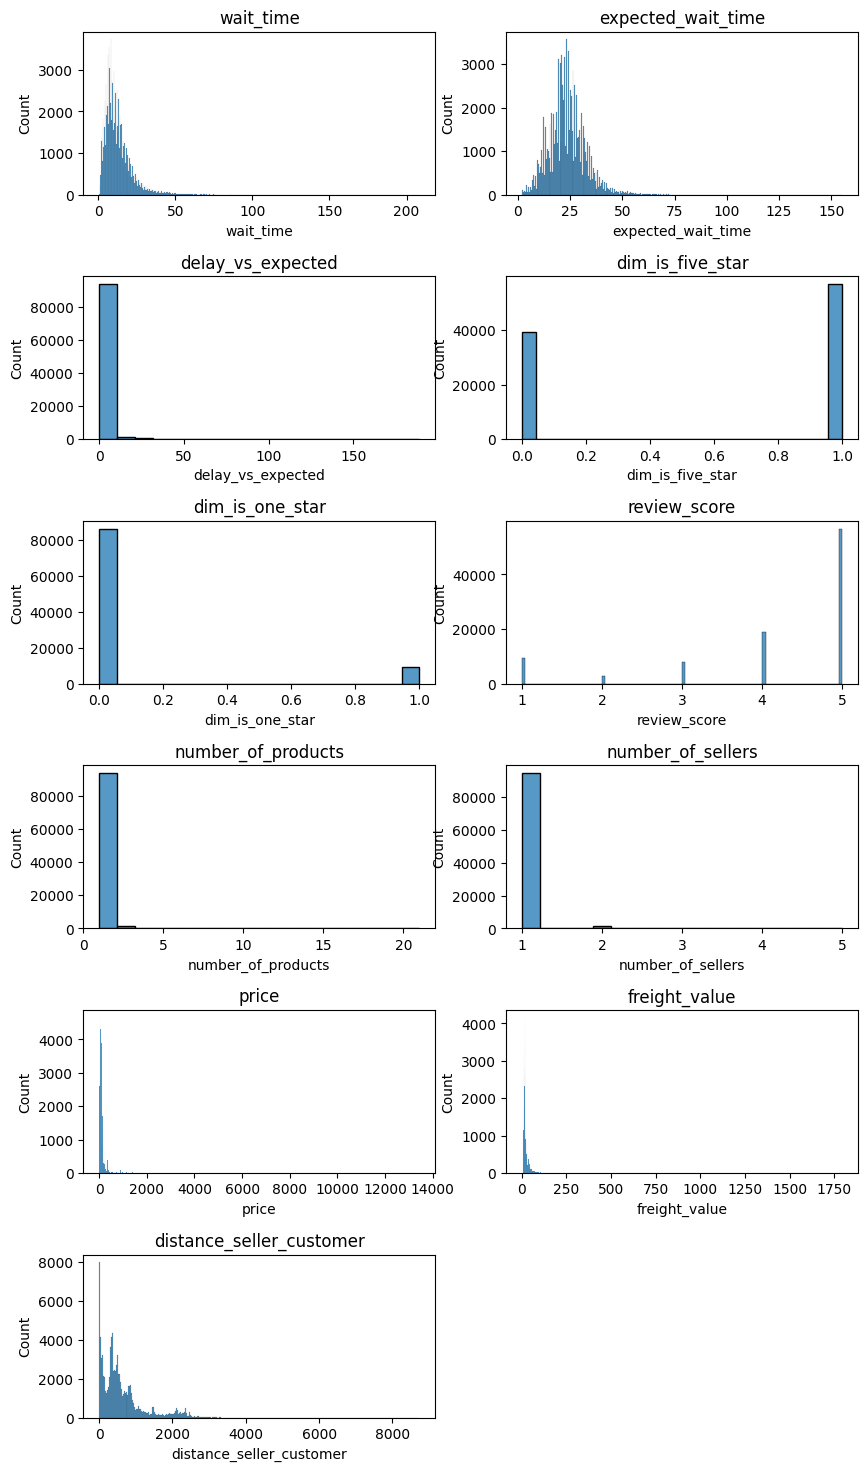

In [7]:
# Select all columns containing only numeric values
orders_numeric = orders.select_dtypes(include = np.number)

num_rows = ((len(orders_numeric.columns) + 1) // 2)
num_cols = 2

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 3 * num_rows))
fig.subplots_adjust(hspace=0.5)

numerical_columns = orders_numeric.columns.tolist()

for i, col in enumerate(numerical_columns):
    sns.histplot(orders_numeric[col], kde=False, ax=axes[i // num_cols, i % num_cols])
    axes[i // num_cols, i % num_cols].set_title(col)

# Blank out unused subplots if any
for i in range(len(orders_numeric.columns), num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.show()

👀 **Creating a `sns.FacetGrid()` of histograms for each `review_score` vs. `wait_time`**

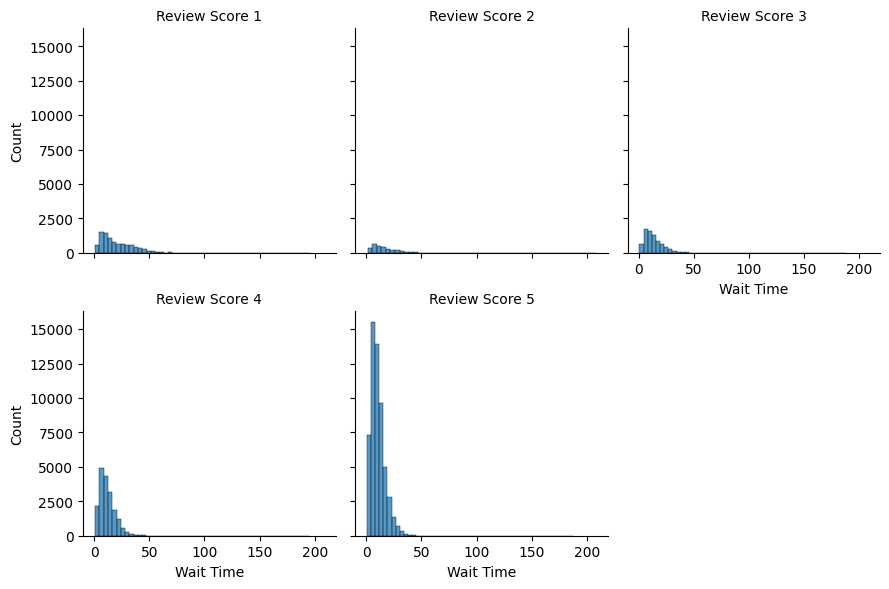

In [8]:
g = sns.FacetGrid(data=orders_numeric, col='review_score', col_wrap=3, height=3)
g.map(sns.histplot, 'wait_time', bins=50, kde=False)

g.set_axis_labels("Wait Time", "Count")
g.set_titles("Review Score {col_name}")

👀 **Creating a `sns.kdeplot()` for `price`, `freight_value` and `distance_seller_customer`**

Text(0.5, 1.0, 'Distribution of Distance Seller-Customer')

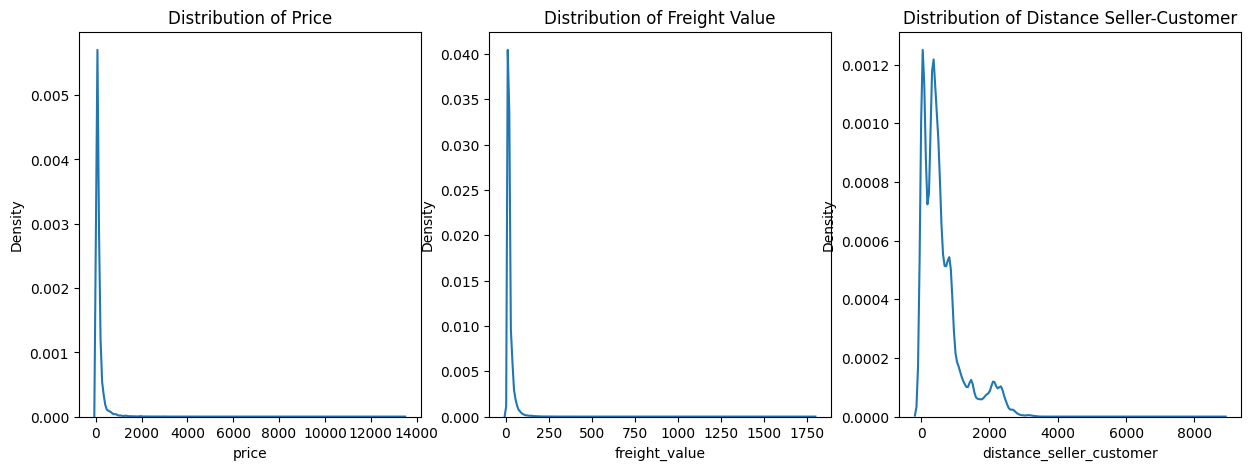

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# KDE Plot for 'price'
sns.kdeplot(orders['price'], ax=axes[0])
axes[0].set_title('Distribution of Price')

# KDE Plot for 'freight_value'
sns.kdeplot(orders['freight_value'], ax=axes[1])
axes[1].set_title('Distribution of Freight Value')

# KDE Plot for 'distance_seller_customer'
sns.kdeplot(orders['distance_seller_customer'], ax=axes[2])
axes[2].set_title('Distribution of Distance Seller-Customer')

❓**Which feature seems to the most correlated with `review_score`?**

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Features')

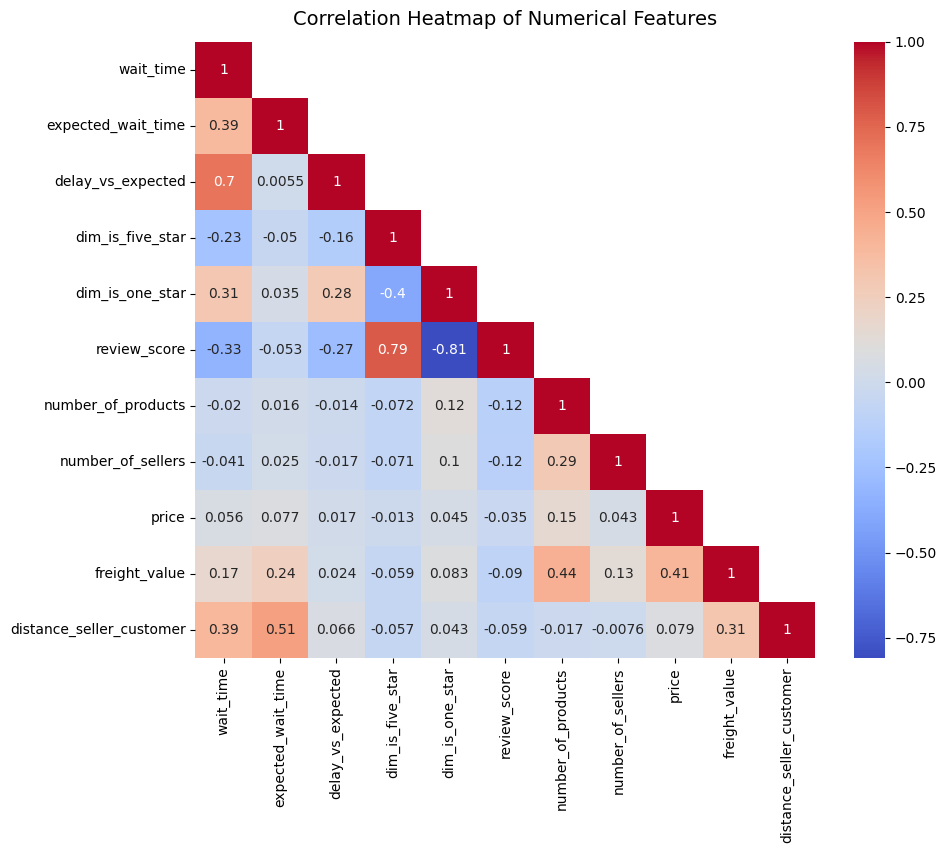

In [21]:
correlation_matrix = orders_numeric.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 10}, mask=mask)
heatmap.set_title('Correlation Heatmap of Numerical Features', fontdict={'fontsize': 14}, pad=12)

👆 **Observations:**  
- Review Score strongly correlates to `dim_is_one_star` (-81%) and `dim_is_five_star` (79%). However, this is redundant, as both of these features are based off of the `review_score` in the first place.
- The next two next highest correlation coefficients with respect to the `review_score` are `wait_time` (-33%) and `delay_vs_expected` (-27%).


## 2. Simple regression of `review_score` against delivery duration

### 2.1 Plots
👀 **Investigating the correlations of `review_score` to `wait_time` and `delay_vs_expected`**

**Notes:**
- Reducing the dataframe to a random sub-sample of 10,000 rows for speed purposes
- Using `DataFrame.sample()` with a fixed `random_state` to avoid changing the sample at each execution
- Adding some `y_jitter` to better visualize the scatterplot density
- Limiting `xlim` and `ylim` to hide outliers

(0.0, 5.836932589132347)

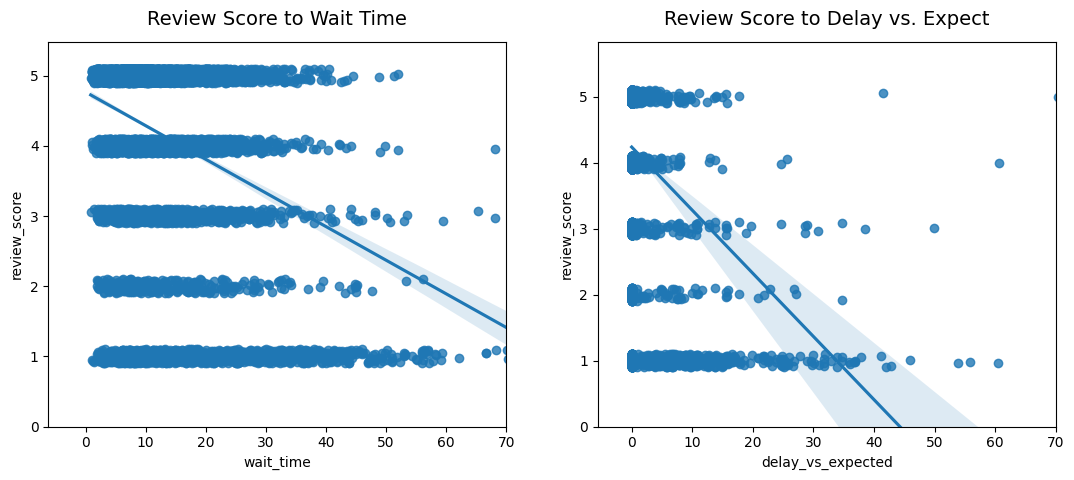

In [26]:
sample = orders.sample(10000, random_state=42)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = sample['wait_time'], y= sample['review_score'], y_jitter=.1).set_title('Review Score to Wait Time', fontdict={'fontsize': 14}, pad=12)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = sample['delay_vs_expected'], y= sample['review_score'], y_jitter=.1).set_title('Review Score to Delay vs. Expect', fontdict={'fontsize': 14}, pad=12)
plt.xlim(right=70)
plt.ylim(bottom=0)

- `Slope wait_time ≈ -0.05` : "For each additional day waiting for an order to be delivered, the review score on average is reduced by 0.05"
- `Slope delay ≈ -0.1` : "For each additional day waiting for an order to be delivered _after the ETA_, the review score on average is reduced by 0.1"

### 2.2 Inferential analysis

Even if I had used all 100,000 orders for these regplots, **how certain** can I be that these coefficients are **statistically significant**?

❓ Questions about the statistical significance of these coefficients:

* Are these coefficients able to generalize well to future orders (all else being equal) ? (*Ideal answer: Yes*) 
* Are we sure that these coefficients do not simply capture random fluctuations due to the limited observation period ? (*Ideal answer: No*) 

👀 I what to estimate the **`confidence interval`** around the mean value for these two slopes:  
- $slope_{\text{wait}} = -0.05 \pm \text{[95\% interval]} $  
- $slope_{\text{delay}} = -0.1 \pm \text{[95\% interval]} $  


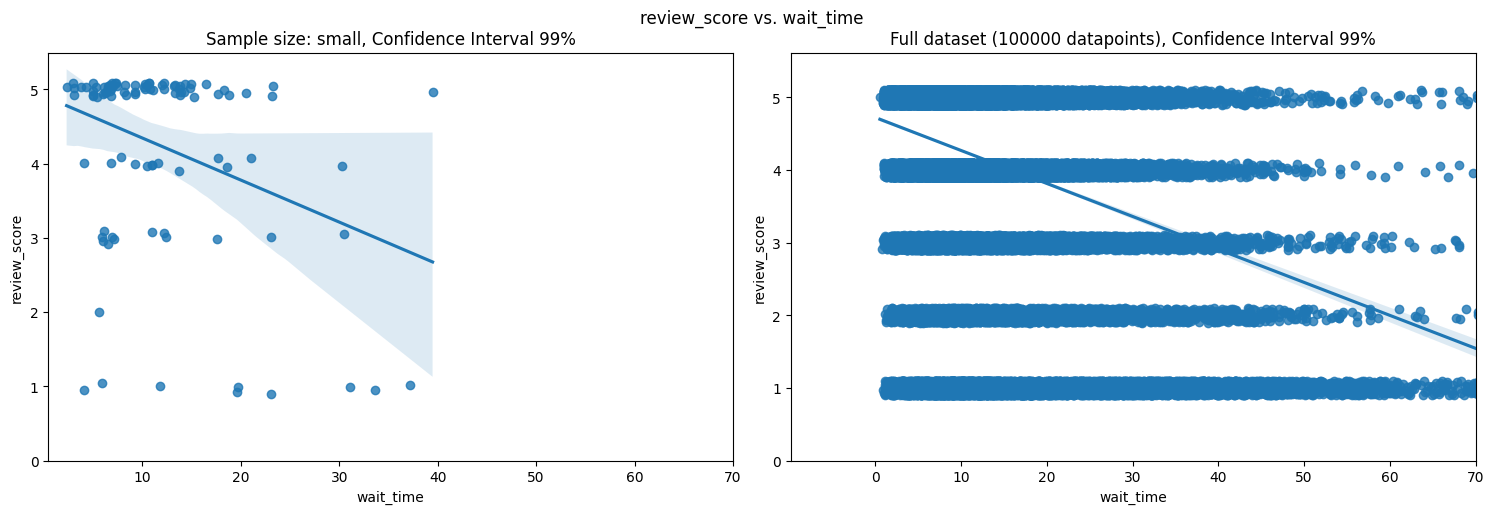

In [28]:
sample = orders.sample(100, random_state=42)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('review_score vs. wait_time')
fig.tight_layout()

sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1, ci=99, ax = axes[0])
axes[0].set_xlim(right=70)
axes[0].set_ylim(bottom=0)
axes[0].set_title("Sample size: small, Confidence Interval 99%")


sns.regplot(x = orders.wait_time, y= orders.review_score, y_jitter=.1, ci=99, ax = axes[1])
axes[1].set_xlim(right=70)
axes[1].set_ylim(bottom=0)
axes[1].set_title("Full dataset (100000 datapoints), Confidence Interval 99%")

plt.show();


### 2.3 Interpretation

* **Null Hypothesis** $H_0$ : "this variable does not influence the review score", a.k.a its coefficient is equal to zero

When plotting all our datapoints:
- The 95% confidence interval for the slope does not contain the value 0.
    - 👉 I am `95% confident that slower deliveries are associated with weaker reviews`.
- The **`p-value`** associated with the null hypothesis "the impact of delivery time on review scores is almost zero" is lower than 5%
    - 👉 I can safely reject this null hypothesis and consider the **`alternative hypothesis`** = `"the delivery time has an impact on the review score"` 

🔥 My findings are said to be **statistically significant**. 

⚠️ However, **correlation does NOT imply causality**. 

- It can take inherently longer to deliver certain products (e.g.heavy products)
    - These categories of products will often have a low review_score, no matter how long their delivery time is. 

👉 Identifying **confounding factor** is crucial and cannot be done with a simple univariate regression. 


